In [2]:
# Basic Imports
import numpy as np
import pandas as pd
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
#plt.style.use('ggplot')

In [3]:
# Data imports
my_name = 'Exp6'
cohort = 'ADNI1'
clinical_scale = 'ADAS13'
exp_name = '{}_{}_{}'.format(my_name,cohort,clinical_scale)
atlas = 'AAL'

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
HC_L_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_left_{}.pkl'.format(cohort,my_name)
HC_R_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_right_{}.pkl'.format(cohort,my_name)
CT_data_path = baseline_dir + 'CT/civet_out/{}_subject_ROI_CT_dict_{}.pkl'.format(cohort,atlas)
CT_unique_ROIs_path = baseline_dir + 'CT/civet_out/ADNI_unique_ROIs_{}.pkl'.format(atlas)
sub_CS_data_path = baseline_dir + 'CS/{}_BL_PTID_{}_dict.pkl'.format(cohort,clinical_scale)
sub_DX_data_path = baseline_dir + 'CS/{}_BL_PTID_DX_bl_dict.pkl'.format(cohort)
sub_age_data_path = baseline_dir + 'CS/{}_age.pkl'.format(cohort)
sub_sex_data_path = baseline_dir + 'CS/{}_sex.pkl'.format(cohort)

In [3]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
#Pick model with its configs/hyper-paramsd
def getModel(model_choice):     
    if model_choice == 'LR_L1':
        model_clf = Lasso(normalize=True, max_iter=100)
        hyper_params = {'alpha':[0.1, 0.01, 0.001]} 
        scale_data = False #Scales HC and CT features    
        feat_imp = False   
        
    elif model_choice == 'SVR':
        model_clf = SVR(max_iter=100)
        hyper_params = {'kernel':['linear','rbf'], 'C':[1,10]}
        scale_data = True #Scales HC and CT features        
        feat_imp = False

    elif model_choice == 'RFR':
        model_clf = RandomForestRegressor(n_jobs=8, max_depth=3,max_features='log2')
        hyper_params = {'n_estimators':[100],'min_samples_split':[10]}    
        scale_data = False    
        feat_imp = False   
        
    else:
        print "Unknown model choice"


    return {'model_clf':model_clf,'hyper_params':hyper_params,'scale_data':scale_data,'feat_imp':feat_imp}

# Some Defs
def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, save_model, save_model_path):
    import collections
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting InnerFold computation'
        save_model_path_fold = save_model_path + '_fold_' 
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y,save_model,save_model_path_fold)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
        
    #CV_scores    
    r_train = stats.pearsonr(clf.predict(train_X),train_y)
    r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)
        
    R2_train = clf.score(train_X,train_y) 
    R2_valid = clf.score(valid_X,valid_y)
        
    MSE_train = mse(clf.predict(train_X),train_y)
    MSE_valid = mse(clf.predict(valid_X),valid_y)
    
    RMSE_train = np.sqrt(mse(clf.predict(train_X),train_y))
    RMSE_valid = np.sqrt(mse(clf.predict(valid_X),valid_y))
    
    print 'Ending OuterFold computation'
    
    return {'r_train':r_train, 'r_valid':r_valid, 'R2_train':R2_train, 'R2_valid':R2_valid,
            'MSE_train':MSE_train, 'MSE_valid':MSE_valid, 'RMSE_train':RMSE_train, 'RMSE_valid':RMSE_valid,
            'hp_dict':hp_dict, 'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y}

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y,save_model,save_model_path):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)
    #Save classifier
    if save_model:
        save_model(clf,save_model_path)
        
    return clf

import tables as tb
from sklearn import preprocessing
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

#Update performance dictionaries for APANN
# One modality and CS at a time

def update_APANN_perf_df(perf_file1, perf_file2):
    df_perf_dict_1 = pickle.load( open(perf_file1, 'rb') )
    df_perf_dict_2 = pickle.load( open(perf_file2, 'rb') )

    df_1 = pd.DataFrame.from_dict(df_perf_dict_1,orient='index')
    df_2 = pd.DataFrame.from_dict(df_perf_dict_2,orient='index')
    
    if len(df_1) != len(df_2):
        print 'Dictionary sizes are not equal'
    
    else:
        for col in ['CV_r','CV_MSE','CV_RMSE']:
            a = df_1[col].values
            b = df_2[col].values
            if col == 'CV_r':
                c = np.maximum(a,b)
            else: 
                c = np.minimum(a,b)
            print 'mean perf for {}, df1:{}, df2:{}, opt(df1,df2):{}'.format(col, np.mean(a), np.mean(b), np.mean(c))
            df_1[col] = c        
        
    return df_1

#Compute signficance of performance differences. If using correlations then use arctanh before the t-test
def computeSignficance(x,y,use_atanh):
    if use_atanh:
        #print 'Transforming correlation values using atan function'
        x = np.arctanh(x)
        y = np.arctanh(y)
        
    #compute t-tests
    t_val, p_val = stats.ttest_rel(x,y)    
    if p_val < 0.001:
        out = '***'
    elif p_val < 0.01:
        out = '**'
    elif p_val < 0.05:
        out = '*'
    else:
        out = ''
        
    return out

In [20]:
# Train and Test models
from functools import partial #Parallelize!!! 

# Load save experimental setup
#cohort = 'ADNI2'
#Clinical_Scale = 'MMSE'
save_CV_perf = True    
# Parallization configs for ipython notebook cluster    
rc = ipp.Client()
dview = rc[:]
dview.push(dict(computeOuterFold = computeOuterFold))
dview.push(dict(innerCVLoop = innerCVLoop))

#----------------------------------
# Iterate through MC folds --> Modalitiies --> --> Model Choices --> k-folds (total 10x3x3x10 runs)
idx = 1
df_perf_dict = {}

#Some paths to store models and performance stats
baseline_dir = '/mnt/tigrlab/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'
CV_model_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/'
save_model = False #do you really want to save all classifiers per each fold? (default false) 

modalities = ['HC','CT','HC_CT']
model_list = ['LR_L1','SVR','RFR']

HC_offset = 16086+16471
MC_runs = 1
n_folds = 10

for cohort in ['ADNI1','ADNI2']:
    if cohort == 'ADNI1':
        exp_name = 'Exp6'
    else:
        exp_name = 'Exp11'
        
    for Clinical_Scale in ['MMSE','ADAS13']:
        if Clinical_Scale == 'ADAS13':
            Clinical_Scale_lowercase = 'adas'
        else:
            Clinical_Scale_lowercase = 'mmse'

        exp_start_time = time.time()
        for m in np.arange(1,MC_runs+1,1):   
            MC_start_time = time.time()
            for modality in modalities:
                modality_start_time = time.time()
                for model_choice in model_list:
                    model_start_time = time.time()
                    print ''
                    print 'MC:{}, cohort: {}, Clinical Scale:{} modality: {}, model: {}'.format(m,cohort,Clinical_Scale,modality,model_choice)
                    model_def = getModel(model_choice)
                    model_clf = model_def['model_clf']
                    hyper_params = model_def['hyper_params']
                    scale_data = model_def['scale_data']    
                    feat_imp = model_def['feat_imp']

                    # Create list of all the fold-subsets (needed for parallelization)
                    X_train_list = []
                    X_valid_list = []
                    y_train_list = []
                    y_valid_list = []    

                    for fid in np.arange(1,n_folds+1,1):
                        if cohort == 'ADNI1':
                            train_data_path = baseline_dir + 'CV_{}_{}_ADAS13_NN_train_MC_{}.h5'.format(exp_name,cohort,m)
                            valid_data_path = baseline_dir + 'CV_{}_{}_ADAS13_NN_valid_MC_{}.h5'.format(exp_name,cohort,m)                
                        else:
                            train_data_path = baseline_dir + 'CV_{}_{}_NN_train_MC_{}.h5'.format(exp_name,cohort,m)
                            valid_data_path = baseline_dir + 'CV_{}_{}_NN_valid_MC_{}.h5'.format(exp_name,cohort,m)                

                        X_train_raw = load_data(train_data_path,'Fold_{}_train_X'.format(fid),'no_preproc')
                        X_valid_raw = load_data(valid_data_path,'Fold_{}_valid_X'.format(fid),'no_preproc')

                        if modality == 'HC_CT':
                            X_train = X_train_raw
                            X_valid = X_valid_raw
                        elif modality == 'HC':
                            X_train = X_train_raw[:,:HC_offset]
                            X_valid = X_valid_raw[:,:HC_offset]               
                        elif modality == 'CT':
                            X_train = X_train_raw[:,HC_offset:]
                            X_valid = X_valid_raw[:,HC_offset:]
                        else:
                            print "Wrong modality selected..."  

                        print 'train_X shape {}, valid_X shape{}'.format(X_train.shape, X_valid.shape)

                        if scale_data:
                            X_train = preprocessing.StandardScaler().fit_transform(X_train)
                            X_valid = preprocessing.StandardScaler().fit_transform(X_valid)

                        y_train = load_data(train_data_path,'Fold_{}_train_{}'.format(fid,Clinical_Scale_lowercase),'no_preproc')
                        y_valid = load_data(valid_data_path,'Fold_{}_valid_{}'.format(fid,Clinical_Scale_lowercase),'no_preproc')


                        X_train_list.append(X_train)
                        X_valid_list.append(X_valid)
                        y_train_list.append(y_train)
                        y_valid_list.append(y_valid)


                    exp_name_long = 'high_dim_CV_perf_{}_{}_{}_{}'.format(exp_name,cohort,Clinical_Scale,m)                                

                    save_model_path = CV_model_dir + exp_name_long + '_' + model_choice

                    CV_r_train=[] #pearson r score for each outer fold on train set
                    CV_r_valid=[] #pearson r score for each outer fold on validation set

                    CV_R2_train=[] #R2 score for each outer fold on train set
                    CV_R2_valid=[] #R2 score for each outer fold on validation set

                    CV_MSE_train=[] #MSE for each outer fold on train set
                    CV_MSE_valid=[] #MSE for each outer fold on validation set

                    CV_RMSE_train=[] #MSE for each outer fold on train set
                    CV_RMSE_valid=[] #MSE for each outer fold on validation set

                    predicted_CV_scores = []
                    actual_CV_scores = []

                    #Parallelize k-folds
                    mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, inner_loop=True, 
                                  save_model=save_model, save_model_path=save_model_path)
                    parallel_result = dview.map_sync(mapfunc, X_train_list, y_train_list, X_valid_list, y_valid_list)    

                    hp_dict = collections.defaultdict(list)
                    for p, pr in enumerate(parallel_result):
                        CV_r_train.append(pr['r_train'])
                        CV_r_valid.append(pr['r_valid'])
                        CV_R2_train.append(pr['R2_train'])
                        CV_R2_valid.append(pr['R2_valid'])
                        CV_MSE_train.append(pr['MSE_train'])
                        CV_MSE_valid.append(pr['MSE_valid'])
                        CV_RMSE_train.append(pr['RMSE_train'])
                        CV_RMSE_valid.append(pr['RMSE_valid'])
                        predicted_CV_scores.append(pr['predicted_fold_score'])
                        actual_CV_scores.append(pr['actual_fold_scores'])

                        df_perf_dict[idx] = {'MC':m,'modality':modality,'model_choice':model_choice,'KF':p+1,
                                             'CV_R2':pr['R2_valid'],'CV_MSE':pr['MSE_valid'],'CV_RMSE':pr['RMSE_valid'],'CV_r':pr['r_valid']}

                        idx+=1
                        for hp in hyper_params:
                            hp_dict[hp].append(pr['hp_dict'][hp])

                    #Find out most frequent hyper-params during cross-val    
                    hp_mode = {}
                    for hp in hyper_params:
                        hp_mode[hp] = mode(hp_dict[hp])[0][0]

                    print 'most frequent hp:' + str(hp_mode)

                    print 'CV r (mean, median, std_err): ' + '{:04.2f},{:04.2f},{:04.2f}'.format(np.mean(zip(*CV_r_valid)[0]),np.median(zip(*CV_r_valid)[0]),stats.sem(zip(*CV_r_valid)[0]))
                    #print 'CV R2 (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_R2_valid),np.median(CV_R2_valid),stats.sem(CV_R2_valid))
                    #print 'CV MSE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_MSE_valid),np.median(CV_MSE_valid),stats.sem(CV_MSE_valid))
                    print 'CV RMSE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_RMSE_valid),np.median(CV_RMSE_valid),stats.sem(CV_RMSE_valid))

                    model_end_time = time.time()
                    print 'model proc time:{} {}'.format(model_choice, (model_end_time-model_start_time)/60)

                modality_end_time = time.time()
                print 'modality proc time: {} {}'.format(modality, (modality_end_time-modality_start_time)/60)
                print ''

            MC_end_time = time.time()
            print 'MC proc time: {} {}'.format(m, (MC_end_time-MC_start_time)/60)


            if save_CV_perf:
                ts = time.time()
                st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
                save_model_filename = '{}_{}_MC_{}_{}.pkl'.format(save_model_path,modality,m,st)
                #old way of saving results
                classifier_model_and_stats = {'best_clf_hyp':hp_mode,'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_RMSE':CV_RMSE_valid, 
                                              'CV_r': CV_r_valid,'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
                pickleIt(classifier_model_and_stats,save_model_filename)                                    


        #Save df style dictionaly for seaborn plots
        df_perf_dict_path = CV_model_dir + 'high_dim_df_perf_dict_{}_{}_{}.pkl'.format(exp_name, cohort, Clinical_Scale)                
        pickleIt(df_perf_dict,df_perf_dict_path)
        print 'saving results at: {}'.format(df_perf_dict_path)

        exp_end_time = time.time()
        print 'exp run time: {} {}'.format(exp_name, (exp_end_time-exp_start_time)/60)


MC:1, cohort: ADNI1, Clinical Scale:MMSE modality: HC, model: LR_L1
train_X shape (19719, 32557), valid_X shape(68, 32557)
train_X shape (19711, 32557), valid_X shape(68, 32557)
train_X shape (19621, 32557), valid_X shape(68, 32557)
train_X shape (19688, 32557), valid_X shape(68, 32557)
train_X shape (19705, 32557), valid_X shape(68, 32557)
train_X shape (19823, 32557), valid_X shape(67, 32557)
train_X shape (20145, 32557), valid_X shape(66, 32557)
train_X shape (19906, 32557), valid_X shape(66, 32557)
train_X shape (19816, 32557), valid_X shape(65, 32557)
train_X shape (19884, 32557), valid_X shape(65, 32557)
most frequent hp:{'alpha': array([ 0.001])}
CV r (mean, median, std_err): 0.39,0.38,0.02
CV RMSE (mean, median, std_err): 2.41,2.39, 0.06
model proc time:LR_L1 29.0152186473

MC:1, cohort: ADNI1, Clinical Scale:MMSE modality: HC, model: SVR
train_X shape (19719, 32557), valid_X shape(68, 32557)
train_X shape (19711, 32557), valid_X shape(68, 32557)
train_X shape (19621, 32557), 

In [ ]:
1181/60 

In [7]:
import seaborn as sns

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/'
cohorts = ['ADNI1','ADNI2']
clinical_scales = ['ADAS13','MMSE']
p=0
for cohort in cohorts:
    for clinical_scale in clinical_scales:        
        print cohort, clinical_scale        
        
        #High-dim Baseline input (masks + SpectClust)
        if cohort=='ADNI1':
            df_perf_dict = pickle.load( open(baseline_dir + 'high_dim_df_perf_dict_Exp6_{}_{}.pkl'.format(cohort,clinical_scale), 'rb') )
        else:
            df_perf_dict = pickle.load( open(baseline_dir + 'high_dim_df_perf_dict_Exp11_{}_{}.pkl'.format(cohort,clinical_scale), 'rb') )
        df = pd.DataFrame.from_dict(df_perf_dict,orient='index')
        df['CV_r_val']= (zip(*df['CV_r'].values)[0])
        df['CV_r_pval']= (zip(*df['CV_r'].values)[1])
        df['cohort_CS']=np.tile('{}_{}_high-dim-input'.format(cohort,clinical_scale),len(df_perf_dict))
        #df['high_dim']=np.tile(True,len(df_perf_dict))
            
        
        for modality in ['CT']:
            for model_choice in ['LR_L1']:                
                stat_values = df[(df.modality==modality) & (df.model_choice==model_choice)][['CV_r_val','CV_RMSE']].values
                print '{},{},  {:3.2f}, {:3.2f},  {:3.2f}, {:3.2f}'.format(modality, model_choice, np.mean(stat_values,axis=0)[0],np.std(stat_values,axis=0)[0],
                                                         np.mean(stat_values,axis=0)[1],np.std(stat_values,axis=0)[1])
            print ''
                
        if p==0:
            df_concat = df
        else:        
            df_concat = df_concat.append(df)
            
        p+=1    
        #Classical Baseline input (vols + AAL)
        df_perf_dict = pickle.load( open(baseline_dir + 'df_perf_dict_Exp6_{}_{}.pkl'.format(cohort,clinical_scale), 'rb') )

        df = pd.DataFrame.from_dict(df_perf_dict,orient='index')
        df['CV_r_val']= (zip(*df['CV_r'].values)[0])
        df['CV_r_pval']= (zip(*df['CV_r'].values)[1])
        df['cohort_CS']=np.tile('{}_{}_low-dim-input'.format(cohort,clinical_scale),len(df_perf_dict))
        #df['high_dim']=np.tile(False,len(df_perf_dict))                
        
        df_concat = df_concat.append(df)
            
        p+=1


#Append APANN dictionary to df
update_perf = True
up_modality = 'HC_CT'
up_cohorts = {'ADNI1':1, 'ADNI2':4,'ADNI1and2':5}
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/output/'
for cohort in cohorts:
    for clinical_scale in clinical_scales:
        for modality in ['HC','CT','HC_CT']:
            if update_perf & (modality == up_modality) & (cohort in up_cohorts.keys()):
                print 'using updated performance for modality: {}, CS: {}'.format(modality,clinical_scale)
                if cohort == 'ADNI2':
                    perf_file1 = baseline_dir + 'df_perf_dict_Exp11_MC_{}_{}_{}_tuned_up_3.pkl'.format(cohort,modality, clinical_scale)
                    perf_file2 = baseline_dir + 'df_perf_dict_Exp11_MC_{}_{}_{}_tuned_up_{}.pkl'.format(cohort,modality, clinical_scale, up_cohorts[cohort])
                elif cohort == 'ADNI1and2':
                    perf_file1 = baseline_dir + 'df_perf_dict_Exp13_MC_{}_{}_{}_tuned_up_4.pkl'.format(cohort,modality, clinical_scale)
                    perf_file2 = baseline_dir + 'df_perf_dict_Exp13_MC_{}_{}_{}_tuned_up_{}.pkl'.format(cohort,modality, clinical_scale, up_cohorts[cohort])
                elif cohort == 'ADNI1':
                    perf_file1 = baseline_dir + 'df_perf_dict_Exp6_MC_{}_{}_{}_tuned.pkl'.format(cohort,modality, clinical_scale)
                    perf_file2 = baseline_dir + 'df_perf_dict_Exp6_MC_{}_{}_{}_tuned_up_{}.pkl'.format(cohort,modality, clinical_scale, up_cohorts[cohort])
                else:
                    print 'unknown cohort'
                    
                df = update_APANN_perf_df(perf_file1, perf_file2)
                
            else:
                if cohort == 'ADNI1':
                    df_perf_dict = pickle.load( open(baseline_dir + 'df_perf_dict_Exp6_MC_{}_{}_{}_tuned.pkl'.format(cohort,modality, clinical_scale), 'rb') )
                elif cohort == 'ADNI2':
                    df_perf_dict = pickle.load( open(baseline_dir + 'df_perf_dict_Exp11_MC_{}_{}_{}_tuned.pkl'.format(cohort,modality, clinical_scale), 'rb') )
                elif cohort == 'ADNI1and2':
                    df_perf_dict = pickle.load( open(baseline_dir + 'df_perf_dict_Exp13_MC_{}_{}_{}_tuned.pkl'.format(cohort,modality, clinical_scale), 'rb') )
                else:
                    print 'unknown cohort'
                
                df = pd.DataFrame.from_dict(df_perf_dict,orient='index')
                
            df['CV_r_val']=df['CV_r']
            df['CV_r_pval']=df['CV_r']*0
            #df['cohort_CS']=np.tile('{}_{}'.format(cohort,clinical_scale),len(df_perf_dict))
            df['cohort_CS']=np.tile('{}_{}_high-dim-input'.format(cohort,clinical_scale),len(df_perf_dict))
            df_concat = df_concat.append(df,ignore_index=True)
            print cohort, clinical_scale
            print '{},{},  {:3.2f}, {:3.2f},  {:3.2f}, {:3.2f}'.format(modality, 'APANN', np.mean(df['CV_r'].values),np.std(df['CV_r'].values),
                                                                     np.mean(df['CV_RMSE'].values),np.std(df['CV_RMSE'].values))
            print ''

ADNI1 ADAS13
CT,LR_L1,  0.51, 0.08,  5.03, 2.81

ADNI1 MMSE
CT,LR_L1,  0.48, 0.09,  2.29, 0.17

ADNI2 ADAS13
CT,LR_L1,  0.54, 0.10,  4.98, 2.72

ADNI2 MMSE
CT,LR_L1,  0.50, 0.09,  4.13, 2.62

ADNI1 ADAS13
HC,APANN,  0.53, 0.09,  7.56, 0.76

ADNI1 ADAS13
CT,APANN,  0.51, 0.10,  7.67, 0.76

using updated performance for modality: HC_CT, CS: ADAS13
mean perf for CV_r, df1:0.600680240705, df2:0.588790549452, opt(df1,df2):0.601711146578
mean perf for CV_MSE, df1:51.1778342494, df2:52.5060185611, opt(df1,df2):51.1184670726
mean perf for CV_RMSE, df1:7.11708360308, df2:7.20698425981, opt(df1,df2):7.11295284127
ADNI1 ADAS13
HC_CT,APANN,  0.60, 0.08,  7.11, 0.72

ADNI1 MMSE
HC,APANN,  0.40, 0.09,  2.41, 0.15

ADNI1 MMSE
CT,APANN,  0.50, 0.09,  2.29, 0.20

using updated performance for modality: HC_CT, CS: MMSE
mean perf for CV_r, df1:0.507682590797, df2:0.511433215326, opt(df1,df2):0.518773185948
mean perf for CV_MSE, df1:5.08569698999, df2:5.05052582986, opt(df1,df2):5.0075587971
mean perf for

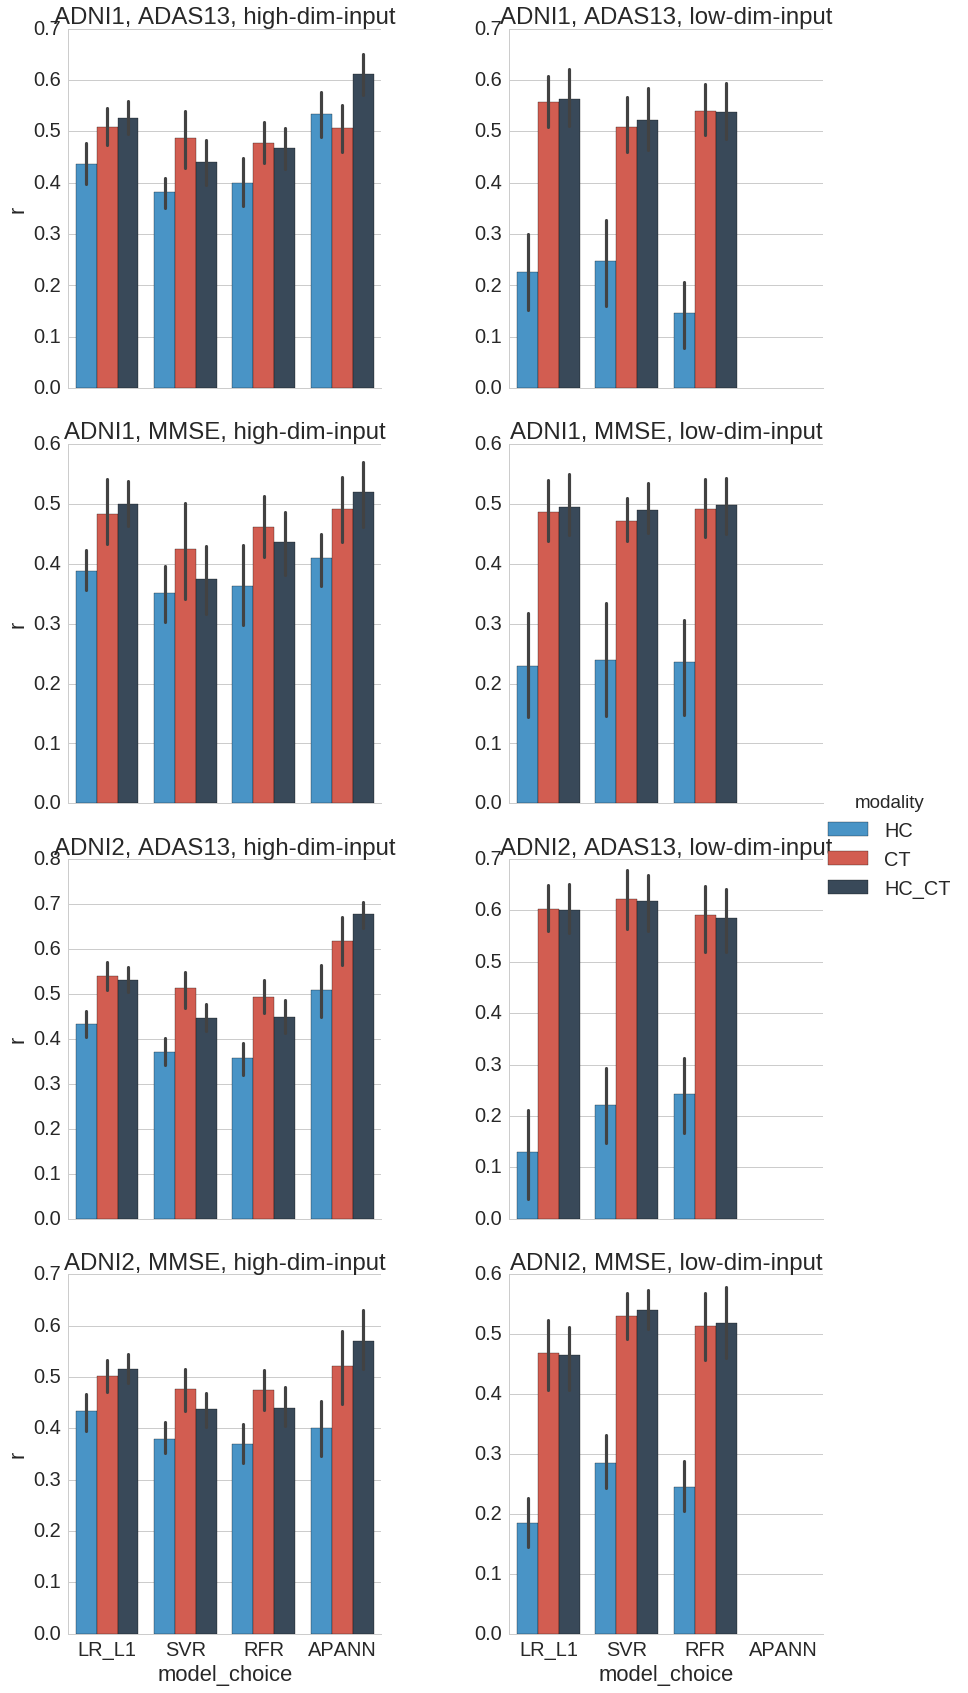

In [18]:
import itertools
# HC,APANN,  0.54,0.06,  7.99,0.59
# CT,APANN,  0.56,0.05,  7.83,0.51
# HC_CT,APANN,  0.63,0.05,  7.33,0.53
# HC,APANN,  0.45,0.06,  2.42,0.14
# CT,APANN,  0.49,0.08,  2.37,0.15
# HC_CT,APANN,  0.54,0.06,  2.26,0.13

#sns.set(style='whitegrid')
#sns.set_style("white")
sns.set(font_scale=2)
save_figure = False

flatui = [ "#3498db", "#e74c3c","#34495e", "#95a5a6", "#9b59b6","#2ecc71",]
palette = sns.color_palette(flatui)
#palette = sns.color_palette('cubehelix',4)

df_concat.rename(columns={'CV_r_val': 'r', 'CV_RMSE': 'RMSE'}, inplace=True)

publish_plots = True
use_atanh = True

if not publish_plots:
    ###Detailed Plots#######
    with sns.axes_style("whitegrid"):
        g = sns.factorplot(x="KF", y="r", hue="modality", col='MC', col_wrap=2,kind="bar",palette=palette, size=6,sharey=False, 
                       data=df_concat[(df_concat.model_choice=='APANN')&(df_concat.cohort_CS=='ADNI1and2_ADAS13')])
    # with sns.axes_style("whitegrid"):
    #     g = sns.factorplot(x="KF", y="CV_MSE", hue="model_choice", col='cohort_CS', col_wrap=2,kind="bar",palette=palette, size=6, sharey=False,
    #                    data=df_concat[(df_concat.modality=='HC_CT')])                                  

else:
    ###Paper Plots#######
    col_order = ['']
    with sns.axes_style("whitegrid"):
        g = sns.factorplot(x="model_choice", y="r", hue="modality", col='cohort_CS',  col_wrap=2, sharey=False,
                       data=df_concat[df_concat.MC==1], kind="bar",palette=palette, size=6)
        

    for ax in g.axes.flat:
        title_str = ax.get_title()
        title = title_str.split(' ')[2].split('_')
        ax.set_title('{}, {}, {}'.format(title[0],title[1],title[2]))

#     with sns.axes_style("whitegrid"):
#         g = sns.factorplot(x="model_choice", y="RMSE", hue="modality", col='cohort_CS',  col_wrap=2, sharey=False,
#                        data=df_concat, kind="bar",palette=palette, size=6)

#     for ax in g.axes.flat:
#         title_str = ax.get_title()
#         title = title_str.split(' ')[2].split('_')
#         ax.set_title('{}, {}'.format(title[0],title[1]))


    # statistical annotation
#     cohort_CS_list = ['ADNI1_ADAS13','ADNI1_MMSE','ADNI2_ADAS13','ADNI2_MMSE','ADNI1and2_ADAS13','ADNI1and2_MMSE']
#     modality = 'HC_CT'
#     model_choices = ['LR_L1','SVR','RFR','APANN']

#     x_offset = 0.25
#     y_offset = 0.04

#     for a, ax in enumerate(g.axes.flat):    
#         cohort_cs = cohort_CS_list[a]    
#         pairs = itertools.combinations(model_choices,2)
#         pair_indices = list((i,j) for ((i,_),(j,_)) in itertools.combinations(enumerate(model_choices), 2))
#         for p, pair in enumerate(pairs):         
#             x = df_concat[(df_concat.cohort_CS == cohort_cs) & (df_concat.modality == modality) & 
#                           (df_concat.model_choice == pair[0])]['r']
#             y = df_concat[(df_concat.cohort_CS == cohort_cs) & (df_concat.modality == modality) & 
#                           (df_concat.model_choice == pair[1])]['r']

#             if len(x) == len(y):
#                 sign = computeSignficance(x,y,use_atanh)
#             else:
#                 l = np.minimum(len(x),len(y))
#                 sign = computeSignficance(x[:l],y[:l],use_atanh)

#             x1 = pair_indices[p][0] + x_offset
#             x2 = pair_indices[p][1] + x_offset
#             y, h, col = 0.65 + y_offset*p, 0, 'k'
#             ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
#             ax.text((x1+x2)*.5, y - 0.025, sign, ha='center', va='bottom', color=col, size=20)

    

if save_figure:
    fig_name = 'Low-dim_vs_high-dim_perf.eps'
    g.savefig(baseline_dir + fig_name, format='eps', dpi=1000) 
    print 'saving fig at: {}'.format(baseline_dir + fig_name)

In [15]:
title[0],title[1],title[2]

(u'ADNI2', u'MMSE', u'low-dim-input')

In [ ]:
# Compute single model from the most frequent hyper-params (for across dataset testing)

#test_clf = Lasso(alpha=0.05)    
#test_clf = SVR(kernel='rbf',C=1)
test_clf = RandomForestRegressor(n_estimators=200,min_samples_split=2,n_jobs=4)

save_CV_perf = False    
if save_CV_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    save_model_filename = save_model_path + '_' + modality + '_' + st + '.pkl'
    classifier_model_and_stats = {'best_clf':test_clf, 'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_r': CV_r_valid,
                                 'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
    pickleIt(classifier_model_and_stats,save_model_filename)
    print 'saving results at: {}'.format(save_model_filename)


In [ ]:
#Get ADNI1 v ADNI2 split sizes for exp13 
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/'
dataset = 'adas'
save_data = True
subset = 'outer_test'
adni1_adni2_split_dict_MC = {}
for mc in np.arange(1,11,1):
    adni1_adni2_split_dict_KF = {}
    for fid in np.arange(1,11,1):
        file1 = baseline_dir + 'MC_{}/fold{}/{}/Exp6_MC.h5'.format(mc,fid,subset)        
        data1_sampx = load_data(file1,dataset,'no_preproc').shape[0]        
        adni1_adni2_split_dict_KF[fid]=data1_sampx
            
    adni1_adni2_split_dict_MC[mc]=adni1_adni2_split_dict_KF
    
print adni1_adni2_split_dict_MC

In [ ]:
#Get ADNI1 v ADNI2 split perf 
import glob
import os
from sklearn.metrics import mean_squared_error as mse

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/'
file_list = glob.glob(baseline_dir + 'Exp6_ADNI1and2*')   
perf_metrics = ['MC','KF','clinical_scale','model_choice','modality','act_scores','pred_scores',
                'sampx_split','r','rmse','dataset']
perf_df = pd.DataFrame(columns=perf_metrics)

print len(file_list)

for file_path in file_list:
    lr_offset = 0
    file_name = os.path.basename(file_path)
    clinical_scale = file_name.split('_')[2]
    mc = int(file_name.split('_')[4])
    if file_name.split('_')[5] == 'LR':
        model_choice = 'LR_L1'
        lr_offset = 1
    else:
        model_choice = file_name.split('_')[5]
        
    if (file_name.split('_')[6+lr_offset] == 'HC') & (file_name.split('_')[7+lr_offset] == 'CT'): 
        modality = 'HC_CT'
    else:
        modality = file_name.split('_')[6+lr_offset]
            
    test_data = pickle.load( open(file_path, "rb" ) )

    act_scores = test_data['actual_CV_scores']
    pred_scores = test_data['predicted_CV_scores']

    for fid in range(10):
        CV_r = stats.pearsonr(act_scores[fid],pred_scores[fid])[0]
        CV_RMSE = np.sqrt(mse(act_scores[fid],pred_scores[fid]))
        split = adni1_adni2_split_dict_MC[mc][fid+1]
        adni1_r = stats.pearsonr(act_scores[fid][:split],pred_scores[fid][:split])[0]
        adni2_r = stats.pearsonr(act_scores[fid][split:],pred_scores[fid][split:])[0]
        adni1_rmse = np.sqrt(mse(act_scores[fid][:split],pred_scores[fid][:split]))
        adni2_rmse = np.sqrt(mse(act_scores[fid][split:],pred_scores[fid][split:]))
        adni1and2_r = stats.pearsonr(act_scores[fid],pred_scores[fid])[0]

         #performance dataframe
        single_perf_dict = [{'MC':mc,'KF':fid+1,'clinical_scale':clinical_scale,'model_choice':model_choice,
                             'modality':modality,'act_scores':act_scores[fid][0],'pred_scores':pred_scores[fid][0],
                             'sampx_split':split,'r':CV_r,'rmse':CV_RMSE,'dataset':'adni1and2'}, 
                           {'MC':mc,'KF':fid+1,'clinical_scale':clinical_scale,'model_choice':model_choice,
                             'modality':modality,'act_scores':act_scores[fid][0],'pred_scores':pred_scores[fid][0],
                             'sampx_split':split,'r':adni1_r,'rmse':adni1_rmse,'dataset':'adni1'},
                           {'MC':mc,'KF':fid+1,'clinical_scale':clinical_scale,'model_choice':model_choice,
                             'modality':modality,'act_scores':act_scores[fid][0],'pred_scores':pred_scores[fid][0],
                             'sampx_split':split,'r':adni2_r,'rmse':adni2_rmse,'dataset':'adni2'}]

        perf_df = perf_df.append(single_perf_dict, ignore_index=True)



In [ ]:
cohort = 'ADNI1and2'
modality = 'HC_CT'
model_choice = 'APANN'
perf_metrics = ['MC','KF','clinical_scale','model_choice','modality','act_scores','pred_scores',
                'sampx_split','r','rmse','dataset']
apann_perf_df = pd.DataFrame(columns=perf_metrics)

for clinical_scale in ['ADAS13','MMSE']:
    df_perf_dict = pickle.load( open(baseline_dir + 'df_perf_dict_Exp13_MC_{}_{}_{}_tuned_up_5.pkl'.format(cohort,modality, clinical_scale), 'rb') )

    for key in df_perf_dict.keys():
        mc = df_perf_dict[key]['MC']
        fid = df_perf_dict[key]['KF']
        act_scores = df_perf_dict[key]['act_scores'][fid][0]
        pred_scores = df_perf_dict[key]['pred_scores'][fid][0]

        CV_r = stats.pearsonr(act_scores,pred_scores)[0]
        CV_RMSE = np.sqrt(mse(act_scores,pred_scores))
        split = adni1_adni2_split_dict_MC[mc][fid]
        adni1_r = stats.pearsonr(act_scores[:split],pred_scores[:split])[0]
        adni2_r = stats.pearsonr(act_scores[split:],pred_scores[split:])[0]
        adni1_rmse = np.sqrt(mse(act_scores[:split],pred_scores[:split]))
        adni2_rmse = np.sqrt(mse(act_scores[split:],pred_scores[split:]))
        adni1and2_r = stats.pearsonr(act_scores,pred_scores)[0]

        #performance dataframe
        single_perf_dict = [{'MC':mc,'KF':fid,'clinical_scale':clinical_scale,'model_choice':model_choice,
                             'modality':modality,'act_scores':act_scores,'pred_scores':pred_scores,
                             'sampx_split':split,'r':CV_r,'rmse':CV_RMSE,'dataset':'adni1and2'}, 
                           {'MC':mc,'KF':fid,'clinical_scale':clinical_scale,'model_choice':model_choice,
                             'modality':modality,'act_scores':act_scores,'pred_scores':pred_scores,
                             'sampx_split':split,'r':adni1_r,'rmse':adni1_rmse,'dataset':'adni1'},
                           {'MC':mc,'KF':fid,'clinical_scale':clinical_scale,'model_choice':model_choice,
                             'modality':modality,'act_scores':act_scores,'pred_scores':pred_scores,
                             'sampx_split':split,'r':adni2_r,'rmse':adni2_rmse,'dataset':'adni2'}]

        apann_perf_df = apann_perf_df.append(single_perf_dict, ignore_index=True)


In [ ]:
split_perf_df_concat = perf_df.append(apann_perf_df, ignore_index=True)
len(split_perf_df_concat)

In [ ]:
#Plot split perfs
# save_path = baseline_dir + 'df_pef_Exp6_ADNI1and2_split.pkl'.format(exp_name)    
# print 'Saving exp_setup to: {}'.format(save_path)    
# pickleIt(perf_df, save_path)
save_figure = False
flatui = ["#2ecc71", "#9b59b6","#34495e", ]
palette = sns.color_palette(flatui)
clinical_scales = ['ADAS13','MMSE']
modality = 'HC_CT'
model_choices = ['LR_L1','SVR','RFR','APANN']
datasets = ['adni1','adni2','adni1and2']

with sns.axes_style("whitegrid"):
        g = sns.factorplot(x="model_choice", y="r", hue="dataset", col='clinical_scale',  col_wrap=2, sharey=False,
                       data=split_perf_df_concat[split_perf_df_concat.modality=='HC_CT'], kind="bar", palette=palette,
                           x_order=model_choices, hue_order=datasets, size=6)
        
        
if save_figure:
    fig_name = 'ADNI1and2_split_perf.eps'
    g.savefig(baseline_dir + fig_name, format='eps', dpi=1000) 
    print 'saving fig at: {}'.format(baseline_dir + fig_name)


        

In [ ]:
x = split_perf_df_concat[(split_perf_df_concat.clinical_scale == 'MMSE') & (split_perf_df_concat.modality == modality) & 
                         (split_perf_df_concat.model_choice == 'SVR') & (split_perf_df_concat.dataset == pair[0])]['r']

np.mean(x)

In [ ]:
#Significance tests for comparing model perf
import itertools
model_choices = ['LR_L1','SVR','RFR','APANN']
modalities = ['HC_CT']
cohort_CS_list = ['ADNI1_ADAS13','ADNI1_MMSE','ADNI2_ADAS13','ADNI2_MMSE','ADNI1and2_ADAS13','ADNI1and2_MMSE']
use_atanh = True
idx=0
print 'use_atanh: {}'.format(use_atanh)
for cohort_cs in cohort_CS_list:    
    for modality in modalities:
        pairs = itertools.combinations(model_choices,2)
        
        for pair in pairs:            
            x = df_concat[(df_concat.cohort_CS == cohort_cs) & (df_concat.modality == modality) & 
                          (df_concat.model_choice == pair[0])]['r']
            y = df_concat[(df_concat.cohort_CS == cohort_cs) & (df_concat.modality == modality) & 
                          (df_concat.model_choice == pair[1])]['r']
            
            if len(x) == len(y):
                sign = computeSignficance(x,y,use_atanh)
            else:
                l = np.minimum(len(x),len(y))
                sign = computeSignficance(x[:l],y[:l],use_atanh)
            print cohort_cs, modality, pair, len(x), len(y), sign
        print ''
            

In [ ]:
# Plotting stuff...
boxplot_config_r = {}
boxplot_config_R2 = {}
boxplot_config_MSE = {}
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/output/'
Clinical_Scale = 'ADAS'
cohort = 'ADNI1'
multi_task = False #For ANN models
if Clinical_Scale == 'ADAS':
    if cohort == 'ADNI1':      
        baseline_models = {'LR_HC*':'Exp6_ADNI1_ADAS13_LR_L1_HC_2016-04-21-15-09-33.pkl',
                           'LR_CT*':'Exp6_ADNI1_ADAS13_LR_L1_CT_2016-04-21-15-13-04.pkl',
                           'LR_HC_CT*':'Exp6_ADNI1_ADAS13_LR_L1_HC_CT_2016-04-21-15-04-00.pkl',
                           'SVR_HC*':'Exp6_ADNI1_ADAS13_SVR_HC_2016-04-21-15-14-29.pkl',
                           'SVR_CT*':'Exp6_ADNI1_ADAS13_SVR_CT_2016-04-21-15-17-53.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI1_ADAS13_SVR_HC_CT_2016-04-21-15-28-22.pkl', 
                           'RFR_HC':'Exp6_ADNI1_ADAS13_RFR_HC_2016-04-21-15-40-32.pkl',
                           'RFR_CT':'Exp6_ADNI1_ADAS13_RFR_CT_2016-04-21-15-38-44.pkl',
                           'RFR_HC_CT':'Exp6_ADNI1_ADAS13_RFR_HC_CT_2016-04-21-15-31-53.pkl'}
        
    if cohort == 'ADNI2':
        baseline_models = {'LR_HC*':'Exp6_ADNI2_ADAS13_LR_L1_HC_2016-04-21-15-07-08.pkl',
                           'LR_CT*':'Exp6_ADNI2_ADAS13_LR_L1_CT_2016-04-21-15-13-32.pkl',
                           'LR_HC_CT*':'Exp6_ADNI2_ADAS13_LR_L1_HC_CT_2016-04-21-15-04-35.pkl',
                           'SVR_HC*':'Exp6_ADNI2_ADAS13_SVR_HC_2016-04-21-15-14-13.pkl',
                           'SVR_CT*':'Exp6_ADNI2_ADAS13_SVR_CT_2016-04-21-15-20-53.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI2_ADAS13_SVR_HC_CT_2016-04-21-15-26-27.pkl', 
                           'RFR_HC':'Exp6_ADNI2_ADAS13_RFR_HC_2016-04-21-15-42-00.pkl',
                           'RFR_CT':'Exp6_ADNI2_ADAS13_RFR_CT_2016-04-21-15-36-31.pkl',
                           'RFR_HC_CT':'Exp6_ADNI2_ADAS13_RFR_HC_CT_2016-04-21-15-34-16.pkl'}
                
    if cohort == 'ADNI1and2':
        baseline_models = {'LR_HC*':'Exp6_concat_LR_L1_HC_2016-04-26-13-36-43.pkl',
                           'LR_CT*':'Exp6_concat_LR_L1_CT_2016-04-26-13-41-43.pkl',
                           'LR_HC_CT*':'Exp6_concat_LR_L1_HC_CT_2016-04-26-13-42-08.pkl',
                           'SVR_HC*':'Exp6_concat_SVR_HC_2016-04-26-13-54-38.pkl',
                           'SVR_CT*':'Exp6_concat_SVR_CT_2016-04-26-13-54-11.pkl',
                           'SVR_HC_CT*':'Exp6_concat_SVR_HC_CT_2016-04-26-13-48-03.pkl', 
                           'RFR_HC':'Exp6_concat_RFR_HC_2016-04-26-13-56-18.pkl',
                           'RFR_CT':'Exp6_concat_RFR_CT_2016-04-26-13-59-21.pkl',
                           'RFR_HC_CT':'Exp6_concat_RFR_HC_CT_2016-04-26-14-04-03.pkl'}
elif Clinical_Scale == 'MMSE':
    if cohort == 'ADNI1':    
        baseline_models = {'LR_HC*':'Exp6_ADNI1_MMSE_LR_L1_HC_2016-05-11-15-16-33.pkl',
                           'LR_CT*':'Exp6_ADNI1_MMSE_LR_L1_CT_2016-05-11-15-17-04.pkl',
                           'LR_HC_CT*':'Exp6_ADNI1_MMSE_LR_L1_HC_CT_2016-05-11-15-17-21.pkl',
                           'SVR_HC*':'Exp6_ADNI1_MMSE_SVR_HC_2016-05-11-15-37-34.pkl',
                           'SVR_CT*':'Exp6_ADNI1_MMSE_SVR_CT_2016-05-11-15-37-08.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI1_MMSE_SVR_HC_CT_2016-05-11-15-34-50.pkl', 
                           'RFR_HC':'Exp6_ADNI1_MMSE_RFR_HC_2016-05-11-15-38-55.pkl',
                           'RFR_CT':'Exp6_ADNI1_MMSE_RFR_CT_2016-05-11-15-42-19.pkl',
                           'RFR_HC_CT':'Exp6_ADNI1_MMSE_RFR_HC_CT_2016-05-11-15-44-15.pkl'}
        
    if cohort == 'ADNI2':
        baseline_models = {'LR_HC*':'Exp6_ADNI2_MMSE_LR_L1_HC_2016-05-11-16-29-36.pkl',
                           'LR_CT*':'Exp6_ADNI2_MMSE_LR_L1_CT_2016-05-11-16-30-11.pkl',
                           'LR_HC_CT*':'Exp6_ADNI2_MMSE_LR_L1_HC_CT_2016-05-11-16-30-25.pkl',
                           'SVR_HC*':'Exp6_ADNI2_MMSE_SVR_HC_2016-05-11-16-30-48.pkl',
                           'SVR_CT*':'Exp6_ADNI2_MMSE_SVR_CT_2016-05-11-16-33-41.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI2_MMSE_SVR_HC_CT_2016-05-11-16-52-01.pkl', 
                           'RFR_HC':'Exp6_ADNI2_MMSE_RFR_HC_2016-05-11-16-54-51.pkl',
                           'RFR_CT':'Exp6_ADNI2_MMSE_RFR_CT_2016-05-11-16-59-24.pkl',
                           'RFR_HC_CT':'Exp6_ADNI2_MMSE_RFR_HC_CT_2016-05-11-18-29-58.pkl'}
                
    if cohort == 'ADNI1and2':
        baseline_models = {'LR_HC*':'Exp6_ADNI1and2_MMSE_LR_L1_HC_2016-05-13-13-17-45.pkl',
                           'LR_CT*':'Exp6_ADNI1and2_MMSE_LR_L1_CT_2016-05-13-13-18-17.pkl',
                           'LR_HC_CT*':'Exp6_ADNI1and2_MMSE_LR_L1_HC_CT_2016-05-13-13-18-35.pkl',
                           'SVR_HC*':'Exp6_ADNI1and2_MMSE_SVR_HC_2016-05-13-13-19-11.pkl',
                           'SVR_CT*':'Exp6_ADNI1and2_MMSE_SVR_CT_2016-05-13-13-28-56.pkl',
                           'SVR_HC_CT*':'Exp6_ADNI1and2_MMSE_SVR_HC_CT_2016-05-13-13-45-58.pkl', 
                           'RFR_HC':'Exp6_ADNI1and2_MMSE_RFR_HC_2016-05-13-13-47-54.pkl',
                           'RFR_CT':'Exp6_ADNI1and2_MMSE_RFR_CT_2016-05-13-13-50-40.pkl',
                           'RFR_HC_CT':'Exp6_ADNI1and2_MMSE_RFR_HC_CT_2016-05-13-13-56-10.pkl'}
        
        
# Not plotted:
# 'LR_L1': 'LR_L1_ADAS13_2015-11-06-12-25-21.pkl'
# 'LR_L1_infl':'LR_L1_ADAS13_inflated_train_parallel_2015-11-27-15-05-17.pkl'
r_means =  {}  
r_medians =  {}
r_sems =  {}
rmse_means =  {}
rmse_sems =  {}
predicted_CV_scores = {}
actual_CV_scores = {}
keys_used = []
for key,val in baseline_models.iteritems():
    pkl_file = open(boxplots_dir + val, 'rb')
    saved_data = pickle.load(pkl_file)
    pkl_file.close()            
    boxplot_config_r[key] = (zip(*saved_data['CV_r'])[0])
    boxplot_config_MSE[key] = (saved_data['CV_MSE'])
    print 'key: {}, mean: {}, median: {}, std: {}'.format(key,np.mean(zip(*saved_data['CV_r'])[0]),
                                              np.median(zip(*saved_data['CV_r'])[0]),
                                              np.std(zip(*saved_data['CV_r'])[0]))
    r_means[key] = (np.mean(zip(*saved_data['CV_r'])[0]))
    r_medians[key] = (np.median(zip(*saved_data['CV_r'])[0]))
    r_sems[key] = (stats.sem(zip(*saved_data['CV_r'])[0]))        

    rmse_means[key] = (np.mean(np.sqrt(saved_data['CV_MSE'])))
    rmse_sems[key] = (stats.sem(np.sqrt(saved_data['CV_MSE'])))  
    if key in ['LR_HC_CT*','SVR_HC_CT*','RFR_HC_CT']:
        predicted_CV_scores[key] = (saved_data['predicted_CV_scores'])
        actual_CV_scores[key] = (saved_data['actual_CV_scores'])
        
# Since ANN model perfs are saved differently :-/
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
if Clinical_Scale == 'ADAS':
    if cohort == 'ADNI1':
        if not multi_task:
            ANN_models ={'CT':'Exp6_ADNI1_ADAS13_NN_CT_2016-07-26-19-27-19.pkl',
                         'HC':'Exp6_ADNI1_ADAS13_NN_HC_2016-07-28-16-18-29.pkl',
                         'HC_CT':'Exp6_ADNI1_ADAS13_NN_HC_CT_2016-07-30-14-15-34.pkl'}
        else:
            ANN_models ={'HC':'Exp6_ADNI1_ADAS13_MMSE_NN_HC_2016-06-02-10-26-05.pkl', 
                         'CT':'Exp6_ADNI1_ADAS13_MMSE_NN_CT_2016-06-01-23-42-45.pkl',
                         'HC_CT':'Exp6_ADNI1_ADAS13_MMSE_NN_HC_CT_2016-05-24-11-35-17.pkl'}

    elif cohort == 'ADNI2':
        if not multi_task:
            ANN_models ={'CT':'Exp7_ADNI2_ADAS13_NN_CT_2016-04-25-15-40-42.pkl',
                         'HC':'Exp7_ADNI2_ADAS13_NN_HC_2016-04-25-22-08-00.pkl',
                         'HC_CT':'Exp11_ADNI2_ADAS13_NN_HC_CT_2016-08-03-20-27-06.pkl'}
        else:
            ANN_models ={'HC':'Exp11_ADNI2_ADAS13_MMSE_NN_HC_2016-06-02-15-02-47.pkl',
                         'CT':'Exp11_ADNI2_ADAS13_MMSE_NN_CT_2016-06-02-18-01-52.pkl',
                         'HC_CT':'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-08-24-18-19-36.pkl'}

    elif cohort == 'ADNI1and2':
        if not multi_task:
            ANN_models ={'CT':'Exp8_ADNI1and2_ADAS13_NN_CT_2016-04-26-13-22-48.pkl',
                         'HC':'Exp8_ADNI1and2_ADAS13_NN_HC_2016-04-26-16-53-38.pkl',
                         'HC_CT':'Exp8_ADNI1and2_ADAS13_NN_HC_CT_2016-05-08-12-06-36.pkl'}
        else:
            ANN_models ={'HC':'Exp14_ADNI1and2_ADAS13_MMSE_NN_HC_2016-06-03-14-04-38.pkl',
                         'CT':'Exp14_ADNI1and2_ADAS13_MMSE_NN_CT_2016-06-02-23-24-00.pkl',
                         'HC_CT':'Exp14_ADNI1and2_ADAS13_MMSE_NN_HC_CT_2016-05-21-11-24-21.pkl'}
        
    else:
        print "Wrong cohort"
        
elif Clinical_Scale == 'MMSE':    
    if cohort == 'ADNI1':    
        if not multi_task:
            ANN_models ={'HC':'Exp6_ADNI1_MMSE_NN_HC_2016-05-10-23-14-55.pkl',
                         'CT':'Exp6_ADNI1_MMSE_NN_CT_2016-05-10-21-28-16.pkl',
                         'HC_CT':'Exp6_ADNI1_MMSE_NN_HC_CT_2016-05-11-10-21-35.pkl'}
        else:
            ANN_models ={'HC':'Exp6_ADNI1_ADAS13_MMSE_NN_HC_2016-06-02-10-26-05.pkl', 
                         'CT':'Exp6_ADNI1_ADAS13_MMSE_NN_CT_2016-06-01-23-42-45.pkl',
                         'HC_CT':'Exp6_ADNI1_ADAS13_MMSE_NN_HC_CT_2016-05-24-11-35-17.pkl'}

    elif cohort == 'ADNI2':
        if not multi_task:
            ANN_models ={'CT':'Exp11_ADNI2_MMSE_NN_CT_2016-05-09-16-07-42.pkl',
                         'HC':'Exp11_ADNI2_MMSE_NN_HC_2016-05-09-18-20-08.pkl',
                         'HC_CT':'Exp11_ADNI2_MMSE_NN_HC_CT_2016-05-14-23-15-06.pkl'}
        else:
            ANN_models ={'HC':'Exp11_ADNI2_ADAS13_MMSE_NN_HC_2016-06-02-15-02-47.pkl',
                         'CT':'Exp11_ADNI2_ADAS13_MMSE_NN_CT_2016-06-02-18-01-52.pkl',
                         'HC_CT':'Exp11_ADNI2_ADAS13_MMSE_NN_HC_CT_2016-08-24-18-19-36.pkl'}

    elif cohort == 'ADNI1and2':
        if not multi_task:
            ANN_models ={'CT':'Exp13_ADNI1and2_MMSE_NN_CT_2016-05-13-19-59-43.pkl',
                         'HC':'Exp13_ADNI1and2_MMSE_NN_HC_2016-05-12-22-59-44.pkl',
                         'HC_CT':'Exp13_ADNI1and2_MMSE_NN_HC_CT_2016-05-16-10-49-37.pkl'}        
        else:
            ANN_models ={'HC':'Exp14_ADNI1and2_ADAS13_MMSE_NN_HC_2016-06-03-14-04-38.pkl',
                         'CT':'Exp14_ADNI1and2_ADAS13_MMSE_NN_CT_2016-06-02-23-24-00.pkl',
                         'HC_CT':'Exp14_ADNI1and2_ADAS13_MMSE_NN_HC_CT_2016-05-21-11-24-21.pkl'}
    else:
        print "Wrong cohort"

        
for key,val in ANN_models.iteritems():
    pkl_file = open(boxplots_dir + val, 'rb')
    saved_data_raw = pickle.load(pkl_file)
    if multi_task:
        saved_data = saved_data_raw['opt_{}'.format(Clinical_Scale)]        
        boxplot_config_r['ANN_'+key] = tuple(saved_data['CV_r'].values())
        boxplot_config_MSE['ANN_'+key] = tuple(saved_data['CV_MSE'].values())
        pkl_file.close()
        print 'key: {}, mean: {}, median: {}, std: {}'.format(key,np.mean(saved_data['CV_r'].values()),
                                                  np.median(saved_data['CV_r'].values()),
                                                  np.std(saved_data['CV_r'].values()))
        r_means['ANN_'+key] = (np.mean(saved_data['CV_r'].values()))
        r_sems['ANN_'+key] = (stats.sem(saved_data['CV_r'].values()))

        rmse_means['ANN_'+key] = (np.mean(np.sqrt(saved_data['CV_MSE'].values())))
        rmse_sems['ANN_'+key] = (stats.sem(np.sqrt(saved_data['CV_MSE'].values())))
        if key == 'HC_CT':
            predicted_CV_scores['ANN_' + key] = (saved_data['predicted_CV_scores'].values())
            actual_CV_scores['ANN_' + key] = (saved_data['actual_CV_scores'].values())
            
    else:
        saved_data = saved_data_raw
        
        boxplot_config_r['ANN_'+key] = (saved_data['CV_r'])
        boxplot_config_MSE['ANN_'+key] = (saved_data['CV_MSE'])
        pkl_file.close()
        print 'key: {}, file: {}, mean: {}, median: {}, std: {}'.format(key,pkl_file,np.mean(saved_data['CV_r']),
                                                  np.median(saved_data['CV_r']),
                                                  np.std(saved_data['CV_r']))
        r_means['ANN_'+key] = (np.mean(saved_data['CV_r']))
        r_sems['ANN_'+key] = (stats.sem(saved_data['CV_r']))

        rmse_means['ANN_'+key] = (np.mean(np.sqrt(saved_data['CV_MSE'])))
        rmse_sems['ANN_'+key] = (stats.sem(np.sqrt(saved_data['CV_MSE'])))
        if key == 'HC_CT':
            predicted_CV_scores['ANN_' + key] = (saved_data['predicted_CV_scores'])
            actual_CV_scores['ANN_' + key] = (saved_data['actual_CV_scores'])            

In [ ]:
#plot foldwise results
plt.rcParams['figure.figsize'] = (20, 20)
fids = np.arange(1,11,1)
for key in ['ANN_CT','ANN_HC','ANN_HC_CT','LR_CT*','SVR_HC_CT*','RFR_HC_CT']: #boxplot_config_r.keys():
    if key in ['ANN_CT','ANN_HC','ANN_HC_CT']:
        custom_marker = 'd'    
        print 'modality: {}, perf: {}'.format(key, boxplot_config_r[key])
    else:
        custom_marker = 'o'        
    
    plt.subplot(2,1,1)
    plt.plot(fids,boxplot_config_r[key],linestyle='None',marker=custom_marker,markersize=15,label=key)
    plt.legend(bbox_to_anchor=[0.5, -0.1], loc='center', ncol=6)    
    plt.xlim(0,11)
    plt.title('{}_{}'.format(cohort, Clinical_Scale))
    

    plt.subplot(2,1,2)
    plt.plot(fids,boxplot_config_MSE[key],linestyle='None',marker=custom_marker,markersize=15,label=key)
    plt.legend(bbox_to_anchor=[0.5, -0.1], loc='center', ncol=6)
    plt.xlim(0,11)
    


In [ ]:
# 

In [ ]:
CS_vals = sub_CS_dict_clean.values()
plt.hist(CS_vals)

In [ ]:
cohort = 'ADNI2'
exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_Exp5_{}_ADAS13.pkl'.format(cohort)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
kf = exp_setup['kf']
adni2_sub_list = exp_setup['common_subs']

In [ ]:
common_keys = list(set(adni1_sub_list) & set(adni2_sub_list))
print len(adni1_sub_list), len(adni2_sub_list)
print common_keys
                

In [ ]:
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/output/'
adni1_RFR_file = 'Exp4_ADNI1_ADAS13_RFR_HC_CT_2016-02-29-15-24-23.pkl'
adni2_RFR_file = 'Exp5_ADNI2_ADAS13_RFR_HC_CT_2016-04-04-16-18-06.pkl'
pkl_file = open(boxplots_dir + adni1_RFR_file, 'rb')
saved_data = pickle.load(pkl_file)
pkl_file.close()            

adni1_act_scores = np.hstack(saved_data['actual_CV_scores'])
adni1_prd_scores = np.hstack(saved_data['predicted_CV_scores'])

pkl_file = open(boxplots_dir + adni2_RFR_file, 'rb')
saved_data = pickle.load(pkl_file)
pkl_file.close()            

adni2_act_scores = np.hstack(saved_data['actual_CV_scores'])
adni2_prd_scores = np.hstack(saved_data['predicted_CV_scores'])

# print np.hstack(adni1_act_scores)
plt.subplot(2,1,1)
plt.scatter(adni1_act_scores,adni1_prd_scores,c='olivedrab')
plt.title('ADNI1 Perf')
plt.xlabel('Actual ADAS scores')
plt.ylabel('Predicted ADAS scores')
plt.subplot(2,1,2)
plt.scatter(adni2_act_scores,adni2_prd_scores,c='olivedrab')
plt.xlabel('Actual ADAS scores')
plt.ylabel('Predicted ADAS scores')
plt.title('ADNI2 Perf')

box_fig = plt.gcf()
box_fig.savefig('/projects/nikhil/ADNI_prediction/input_datasets/CS/adas_correlations.png', bbox_inches='tight')



In [ ]:
hdf_data = h5.File(hdf_file) 
hdf_data.close() 
FILTERS = tb.Filters(complevel=5,complib='zlib')    
fileh = tb.open_file(hdf_file, mode='r', filters=FILTERS)
fileh.close()

In [ ]:
# creates a new hdf file and copies certain datasets from a old file to the new file 
#  (Since deleting particular dataset is a mess for hdf!)
def copyHDFsubsets(in_file, out_file, datasets):
    comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
    for dataset in datasets:
        cp_data = load_data(in_file, dataset,'no_preproc')
    
        with h5py.File(out_file, 'a') as f:                 
            f.create_dataset(dataset, data=cp_data, **comp_kwargs)

In [ ]:
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/'
for mc in range(2,11,1):
    for fid in range(1,11,1):
        in_file = baseline_dir + 'MC_{}/fold{}/outer_test/Exp6_MC.h5.bk'.format(mc,fid)
        out_file = baseline_dir + 'MC_{}/fold{}/outer_test/Exp6_MC.h5'.format(mc,fid)
        datasets = ['X_CT','X_L_HC','X_R_HC','adas','dx','mmse']
        copyHDFsubsets(in_file, out_file, datasets)

In [ ]:
import h5py
in_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'
subset = 'valid'
exp_name= 'Exp11'
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}

for mc in np.arange(1,2,1):
    out_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/MC_{}/'.format(mc)

    out_file = out_dir + 'fold{}/outer_test/{}_MC.h5'.format(exp_name)

    for fid in np.arange(1,2,1):
#       #inner train and test
#         in_file = in_dir + 'CV_Exp6_ADNI1_NN_OuterFold_MC_{}_fold{}_{}_InnerFold_1.h5'.format(mc,fid,subset)
#         ct_data = load_data(in_file,'Fold_{}_CT_SpecCluster_dyn'.format(fid), 'no_preproc')

        #outer test
        in_file = in_dir + 'CV_Exp6_ADNI1_ADAS13_NN_{}_MC_{}.h5'.format(subset,mc)
        ct_data = load_data(in_file,'Fold_{}_X_R_CT'.format(fid), 'no_preproc')


        with h5py.File(out_file.format(fid), 'a') as f:                 
            f.create_dataset('X_CT_SpecCluster_dyn', data=ct_data, **comp_kwargs)